# Importar modulos / librerias

In [ ]:
import sys
sys.path.append('/content')


In [1]:
# import data

import classifier
from random import randint, random, uniform
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
from IPython.display import display


%matplotlib inline

# Modelo de sistema clasificador difuso (algoritmo genético estilo Pittsburg)


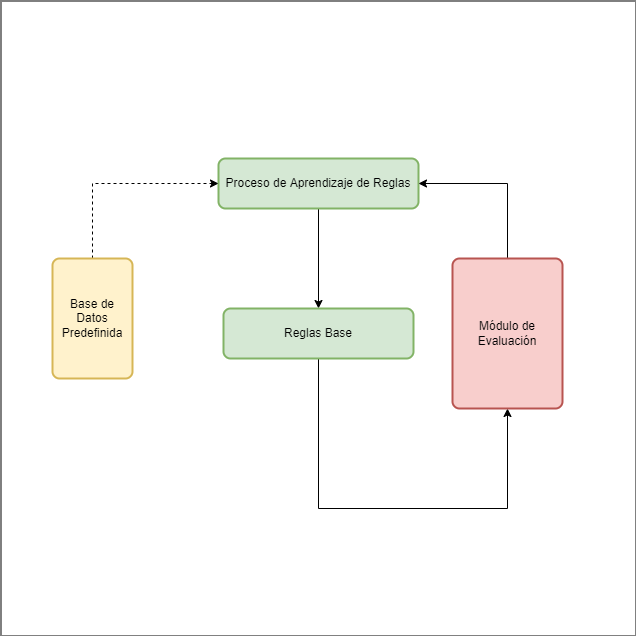

In [ ]:
image = Image.open("./macroalgoritmos/clasificador_difuso.png")

display(image)

# Cargar datos de Juego Lunar Lander

In [2]:
lunar_data = pd.read_csv('./lunar_data.csv')

lunar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9553 entries, 0 to 9552
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Episode No         9553 non-null   int64  
 1   X Coordinate       9553 non-null   float64
 2   Y Coordinate       9553 non-null   float64
 3   Linear Veocity X   9553 non-null   float64
 4   Linear Velocity Y  9553 non-null   float64
 5   Angle              9553 non-null   float64
 6   Angular Velocity   9553 non-null   float64
 7   Leg1               9553 non-null   int64  
 8   Leg2               9553 non-null   int64  
 9   Action             9553 non-null   int64  
dtypes: float64(6), int64(4)
memory usage: 746.5 KB


## Crear modelo de datos de aprendizaje

In [3]:
# Obtener subconjunto X

columnas = ['X Coordinate', 'Y Coordinate', 'Linear Veocity X', 'Linear Velocity Y']

lunar_ep = lunar_data.loc[lunar_data['Episode No'] <= 4000]

ep_data = lunar_ep[columnas]

# Obtener subconjunto y

act_data = lunar_ep[['Action']]

# Normalizar datos

ep_data = ep_data.apply(lambda x: x / np.max(x))

# Entrenar conjunto de datos

X_train, X_test, y_train, y_test = train_test_split(ep_data, act_data, test_size=0.2, random_state=0)

# Reindexar todos
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Mostrar datos
print("Conjunto de Entrenamiento: ")
# print(X_train.info())
print(X_train.shape)

print("Conjunto del Test: ")
# print(X_test.info())
print(X_test.shape)

print("Entrenamiento para el Objetivo: ",)
print(y_train['Action'].unique())
print(y_train.shape)

print("Test Objetivo: ")
print(y_test.shape)
print("------------------------")
print(y_train.head())

Conjunto de Entrenamiento: 
(7642, 4)
Conjunto del Test: 
(1911, 4)
Entrenamiento para el Objetivo: 
[1 0 3 2]
(7642, 1)
Test Objetivo: 
(1911, 1)
------------------------
   Action
0       1
1       0
2       0
3       1
4       1


# Proceso de algoritmo genético

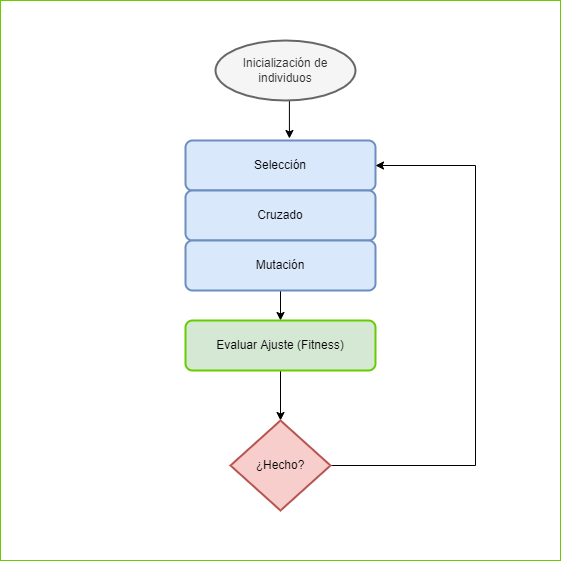

In [ ]:
image = Image.open("./macroalgoritmos/algoritmo_genetico.png")

display(image)

In [4]:
import warnings
warnings.filterwarnings("ignore")

#### VARIABLES GA ####
mutProb = .1
tournamentSize = 3
elitism = True
popSize = 15
GENERATION_NUMBER = 20
# ------------------- #
# Peso de los parametros de funcion para calcular fitness
# ALPHA = 0.6
# BETA = 0.4

# Crear clases Individuo y Poblacion

class Indiv:
    def __init__(self, init=True):
        self.rules = []
        if init:
            for i in range(classifier.nbRules):
                self.rules.append(classifier.generateRule())

    def __str__(self):
        s = ""
        for i in range(classifier.nbRules):
            s += "Regla " + str(i) + ": " + str(self.rules[i]) + "\t"
            s += str(classifier.getConf(self.rules[i])) + "\n"
        return s

    def getFitness(self):
        acc = classifier.getAccuracy(self)
        goodRulesNb, badRulesNb = classifier.checkRules(self)
        complexity = classifier.calcComplexity(self)

        w1 = 0.6
        w2 = 0.4

        score = w1 * (1.0 - acc) + w2 * (float(complexity) / float(len(self.rules) * 4))
        # this maximizes the accuracy and minimizes "complexity"
        score = -1 * score

        return score

        # 1 - nbofaccuratelyclassified / number of cases find

        # inferences = classifier.infer(self.rules)
        # inferences = classifier.simple_infer(self.rules)
        # return classifier.computeFitness(inferences)


class Population:
    """ x = Indiv()
    x.getfit()"""

    def __init__(self, init, size=popSize):
        if init:
            self.listpop = [Indiv() for _ in range(size)]
        else:
            self.listpop = []

    def getFittest(self):
        nb_max = self.listpop[0].getFitness()
        index = 0

        for i in range(1, len(self.listpop)):
            nextFitness = self.listpop[i].getFitness()
            if nextFitness > nb_max:
                nb_max = nextFitness
                index = i
        return self.listpop[index]

# FUNCIONES PARA PROCESO DE ALGORITMO GENETICO
def tournament(pop):
    tourList = Population(False, tournamentSize)

    for j in range(tournamentSize):
        indexT = randint(0, popSize - 1)

        pop.listpop[indexT]
        tourList.listpop.append(pop.listpop[indexT])

    return tourList.getFittest()


def crossOver(Indiv1, Indiv2):
    newIndiv = Indiv(False)

    for i in range(classifier.nbRules):
        rule1 = Indiv1.rules[i]

        rule2 = Indiv2.rules[i]

        newIndiv.rules.append(crossoverRules(rule1, rule2))

    return newIndiv


def crossoverRules(rule1, rule2):
    newRule = []

    for i in range(len(rule1)):
        prob = random()
        if prob < 0.5:
            newRule.append(rule1[i])

        else:
            newRule.append(rule2[i])

    return newRule


def mutation(indiv):
    for i in range(classifier.nbRules):

        for j in range(classifier.nbRules):

            prob = random()

            if prob < mutProb:
                indiv.rules[i][j] = 1 - indiv.rules[i][j]


# Obtener set de reglas y salidas del resultado
def getRulesfromFittest(thisFittest):
    reglas = []
    salidas = []
    for i in range(len(thisFittest.rules)):
        reglas.append(thisFittest.rules[i])
        salidas.append(classifier.getConf(thisFittest.rules[i]))
    return reglas, salidas


# Insertar datos de la sub clase correpondiente a la clase de la regla
def getRulesSubClass(rule, i, ruleclass, subclass):
    rule_text = ""
    if not (rule[i] == 0) and not ((rule[i + 1] == 0) or (rule[i + 2] == 0)):
        rule_text += ruleclass + " = " + subclass + " or "
    elif not (rule[i] == 0) and (rule[i + 1] == 0) and (rule[i + 2] == 0):
        rule_text += ruleclass + " = " + subclass + " and "
    if not (rule[i + 1] == 0) and not (rule[i + 2] == 0):
        rule_text += ruleclass + " = " + subclass + " or "
    elif not (rule[i + 1] == 0) and (rule[i + 2] == 0):
        rule_text += ruleclass + " = " + subclass + " and "
    if not (rule[i + 2] == 0):
        rule_text += ruleclass + " = " + subclass + " and "
    return rule_text


# Transformar reglas binarias en reglas literales
def binRulestoClassRules (rules, outputs, entrada, salida, subclase):
    soltext = []
    count = 0
    for rule in rules:
        rule_text = ""
        textosalida = ""
        for i in range(0, len(rule), 3):
            if i < 2:
                rule_text += getRulesSubClass(rule, i, entrada[0], subclase[0])
            elif 2 <= i < 5:
                rule_text += getRulesSubClass(rule, i, entrada[1], subclase[1])
            elif 5 <= i < 8:
                rule_text += getRulesSubClass(rule, i, entrada[2], subclase[2])
            elif 8 <= i < 11:
                rule_text += getRulesSubClass(rule, i, entrada[3], subclase[3])
        rule_text_2 = rule_text.rstrip('and ')
        # Output process
        tupla = outputs[count]
        if tupla[0] == 0:
            textosalida += salida[0]
        elif tupla[0] == 1:
            textosalida += salida[1]
        elif tupla[0] == 2:
            textosalida += salida[2]
        else:
            textosalida += "Not Valid"
        rule_text_2 += " entonces " + textosalida
        soltext.append(rule_text_2)
        count += 1
    return soltext


# Obtener valor de parametros de subclase
def getSubClassValue(parametro_box, subclase):
    if parametro_box == subclase[0]:
        return round(uniform(0, 0.25), 3)
    elif parametro_box == subclase[1]:
        return round(uniform(0.25, 0.75), 3)
    elif parametro_box == subclase[2]:
        return round(uniform(0.75, 1), 3)
    else:
        return 0    
    
# Crear clase poblacion para comenzar a generar reglas

pop = Population(True)
# Se realiza en cada generacion el proceso de torneo y mutacion

fit_rules = []

for i in range(GENERATION_NUMBER):

    newpop = Population(False)
    print("Generacion numero : {}".format(str(i)))

    for j in range(popSize):
        # Proceso de torneo
        parent1 = tournament(pop)
        parent2 = tournament(pop)

        child = crossOver(parent1, parent2)
        newpop.listpop.append(child)

    for j in range(popSize):
        # Proceso de mutacion
        mutation(newpop.listpop[j])

    pop = newpop
    # Mostrar el mejor set de reglas en la poblacion
    thisFittest = pop.getFittest()
    print("Mejor precision ajustada : {}".format(str(classifier.getAccuracy(thisFittest))))
    print(thisFittest)
    fit_rules.append(classifier.getAccuracy(thisFittest))

# Mostrar la complejidad del set de reglas
print("Calculo de complejidad final: {}".format(classifier.calcComplexity(thisFittest)))
# Obtener set de reglas con salida y guardar en Main()
reglas, salidas = getRulesfromFittest(thisFittest)

Generacion numero : 0


/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  datum = data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.i

Mejor precision ajustada : 0.23480947476828012
Regla 0: [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0]	(3, 0.7504675464528147)
Regla 1: [1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1]	(2, 0.28546658641497846)
Regla 2: [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0]	(1, 0.272501987020611)
Regla 3: [0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0]	(-1, 0)
Regla 4: [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]	(1, 0.2903772406955258)
Regla 5: [0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1]	(1, 0.26532788270701624)
Regla 6: [0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]	(1, 0.2675546581053392)
Regla 7: [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]	(0, 0.2795730332162323)

Generacion numero : 1


/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

Mejor precision ajustada : 0.23274974253347064
Regla 0: [0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0]	(2, 0.2823056406229042)
Regla 1: [1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1]	(3, 0.3158219394938814)
Regla 2: [0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0]	(0, 0.26645783027979086)
Regla 3: [0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0]	(3, 0.26485620047810626)
Regla 4: [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1]	(1, 0.268404277826863)
Regla 5: [0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1]	(1, 0.26532788270701624)
Regla 6: [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]	(-1, 0)
Regla 7: [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0]	(2, 0.290176875526226)

Generacion numero : 2


/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

Mejor precision ajustada : 0.22760041194644695
Regla 0: [0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1]	(1, 0.2881519334608081)
Regla 1: [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]	(2, 0.4642978806754802)
Regla 2: [1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0]	(1, 0.2716379552883771)
Regla 3: [1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1]	(1, 0.26164055283708443)
Regla 4: [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1]	(1, 0.2741524656103612)
Regla 5: [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1]	(2, 0.3887618696169795)
Regla 6: [0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1]	(0, 0.33131372731580383)
Regla 7: [0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0]	(1, 0.26050198359603005)

Generacion numero : 3


/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

Mejor precision ajustada : 0.22142121524201855
Regla 0: [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1]	(2, 0.2853661679791727)
Regla 1: [1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1]	(3, 0.34353166592108775)
Regla 2: [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1]	(1, 0.27442575399782)
Regla 3: [0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1]	(1, 0.26532788270701624)
Regla 4: [1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]	(1, 0.2746640154679921)
Regla 5: [0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1]	(-1, 0)
Regla 6: [1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0]	(1, 0.2899571738504208)
Regla 7: [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0]	(1, 0.26057824472722846)

Generacion numero : 4


/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

Mejor precision ajustada : 0.2203913491246138
Regla 0: [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0]	(1, 0.27504395482365346)
Regla 1: [1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1]	(3, 0.34353166592108775)
Regla 2: [1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1]	(3, 0.3158219394938814)
Regla 3: [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1]	(0, 0.33131372731580383)
Regla 4: [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]	(1, 0.27662551746747366)
Regla 5: [0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]	(-1, 0)
Regla 6: [1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]	(1, 0.28745866941998444)
Regla 7: [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0]	(1, 0.26057824472722846)

Generacion numero : 5


/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

Mejor precision ajustada : 0.23583934088568487
Regla 0: [1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0]	(2, 0.2902933924303118)
Regla 1: [1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1]	(3, 0.3158219394938814)
Regla 2: [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]	(0, 0.2577189173408612)
Regla 3: [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1]	(2, 0.2665734400074164)
Regla 4: [1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1]	(1, 0.27497477662862063)
Regla 5: [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]	(1, 0.27124462861360776)
Regla 6: [1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]	(0, 0.33131372731580383)
Regla 7: [1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0]	(-1, 0)

Generacion numero : 6


/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

Mejor precision ajustada : 0.23069001029866118
Regla 0: [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]	(2, 0.290176875526226)
Regla 1: [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]	(3, 0.33344832061157065)
Regla 2: [0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1]	(1, 0.2881519334608081)
Regla 3: [0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]	(-1, 0)
Regla 4: [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]	(1, 0.27444795541650086)
Regla 5: [0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0]	(2, 0.2754524526712718)
Regla 6: [1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]	(2, 0.4642978806754802)
Regla 7: [0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0]	(0, 0.25791032608028813)

Generacion numero : 7


/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

Mejor precision ajustada : 0.23789907312049433
Regla 0: [1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0]	(2, 0.2754879077292524)
Regla 1: [1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1]	(3, 0.3545643581934114)
Regla 2: [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0]	(2, 0.2985880280987516)
Regla 3: [1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1]	(1, 0.27377732872704685)
Regla 4: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]	(3, 0.342167347322977)
Regla 5: [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0]	(-1, 0)
Regla 6: [0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0]	(1, 0.27147978797261185)
Regla 7: [1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1]	(2, 0.26954324347753345)

Generacion numero : 8


/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

Mejor precision ajustada : 0.22142121524201855
Regla 0: [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0]	(1, 0.27504395482365346)
Regla 1: [1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]	(3, 0.3158219394938814)
Regla 2: [0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1]	(3, 0.3158219394938814)
Regla 3: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]	(1, 0.2707724268660138)
Regla 4: [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1]	(1, 0.27497477662862063)
Regla 5: [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0]	(2, 0.2721638290428673)
Regla 6: [1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1]	(2, 0.4642978806754802)
Regla 7: [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0]	(1, 0.26353173993138085)

Generacion numero : 9


/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

Mejor precision ajustada : 0.2286302780638517
Regla 0: [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0]	(1, 0.28325140573920027)
Regla 1: [1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1]	(3, 0.3158219394938814)
Regla 2: [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]	(3, 0.3316078345275784)
Regla 3: [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1]	(2, 0.26908803702114265)
Regla 4: [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1]	(1, 0.27497477662862063)
Regla 5: [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0]	(1, 0.2741204448058307)
Regla 6: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1]	(1, 0.2714991418460042)
Regla 7: [1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0]	(1, 0.26462529186144035)

Generacion numero : 10


/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

Mejor precision ajustada : 0.24098867147270855
Regla 0: [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]	(1, 0.2843093836759564)
Regla 1: [0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1]	(1, 0.2881519334608081)
Regla 2: [1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1]	(3, 0.3545643581934114)
Regla 3: [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1]	(2, 0.26908803702114265)
Regla 4: [0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]	(1, 0.2746640154679921)
Regla 5: [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0]	(1, 0.2741204448058307)
Regla 6: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1]	(1, 0.2722735856651688)
Regla 7: [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]	(3, 0.2599428841061684)

Generacion numero : 11


/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

Mejor precision ajustada : 0.23480947476828012
Regla 0: [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0]	(1, 0.28325140573920027)
Regla 1: [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1]	(1, 0.2881519334608081)
Regla 2: [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1]	(3, 0.36054930194895807)
Regla 3: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]	(1, 0.2714420392733515)
Regla 4: [0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]	(1, 0.2746640154679921)
Regla 5: [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0]	(1, 0.2741204448058307)
Regla 6: [1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1]	(1, 0.2747025387537803)
Regla 7: [0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0]	(2, 0.28377636102174914)

Generacion numero : 12


/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

Mejor precision ajustada : 0.25437693099897013
Regla 0: [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0]	(2, 0.2721638290428673)
Regla 1: [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]	(1, 0.2881519334608081)
Regla 2: [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0]	(0, 0.26139007933812725)
Regla 3: [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1]	(2, 0.26908803702114265)
Regla 4: [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1]	(3, 0.3545643581934114)
Regla 5: [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]	(2, 0.29256313202661904)
Regla 6: [0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0]	(-1, 0)
Regla 7: [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0]	(1, 0.26145239982442436)

Generacion numero : 13


/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

Mejor precision ajustada : 0.23583934088568487
Regla 0: [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0]	(2, 0.2794647134424201)
Regla 1: [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]	(1, 0.2881519334608081)
Regla 2: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]	(3, 0.342167347322977)
Regla 3: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]	(1, 0.2707724268660138)
Regla 4: [0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1]	(1, 0.2690949986268529)
Regla 5: [1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0]	(1, 0.27405431514929834)
Regla 6: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0]	(1, 0.2732079123628844)
Regla 7: [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]	(0, 0.2719548421411732)

Generacion numero : 14


/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

Mejor precision ajustada : 0.25231719876416064
Regla 0: [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0]	(2, 0.290176875526226)
Regla 1: [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]	(3, 0.31391053843662764)
Regla 2: [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]	(3, 0.3256470855617583)
Regla 3: [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1]	(2, 0.26908803702114265)
Regla 4: [1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1]	(3, 0.3545643581934114)
Regla 5: [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]	(-1, 0)
Regla 6: [1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0]	(1, 0.27362786202891043)
Regla 7: [1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0]	(2, 0.26073096719607347)

Generacion numero : 15


/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

Mejor precision ajustada : 0.24407826982492276
Regla 0: [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]	(2, 0.27171239724139984)
Regla 1: [1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1]	(3, 0.3545643581934114)
Regla 2: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]	(-1, -1)
Regla 3: [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1]	(2, 0.2649039254711294)
Regla 4: [1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1]	(3, 0.3316078345275784)
Regla 5: [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0]	(2, 0.27485208975065284)
Regla 6: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0]	(0, 0.33131372731580383)
Regla 7: [0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]	(2, 0.27862847597754464)

Generacion numero : 16


/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

Mejor precision ajustada : 0.2399588053553038
Regla 0: [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]	(2, 0.2794647134424201)
Regla 1: [1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1]	(3, 0.3545643581934114)
Regla 2: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]	(-1, -1)
Regla 3: [0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1]	(1, 0.27024816648833944)
Regla 4: [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1]	(1, 0.2739356043319736)
Regla 5: [1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0]	(2, 0.2721638290428673)
Regla 6: [0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0]	(-1, 0)
Regla 7: [1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0]	(3, 0.2644423533620698)

Generacion numero : 17


/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

Mejor precision ajustada : 0.23069001029866118
Regla 0: [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0]	(2, 0.27485208975065284)
Regla 1: [1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1]	(3, 0.34353166592108775)
Regla 2: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]	(-1, -1)
Regla 3: [0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1]	(1, 0.27024816648833944)
Regla 4: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]	(1, 0.2762276354153679)
Regla 5: [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0]	(2, 0.2902933924303118)
Regla 6: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0]	(1, 0.2725517301183713)
Regla 7: [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]	(3, 0.2599428841061684)

Generacion numero : 18


/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

Mejor precision ajustada : 0.23480947476828012
Regla 0: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]	(2, 0.27101138390248425)
Regla 1: [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1]	(3, 0.3316078345275784)
Regla 2: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]	(-1, -1)
Regla 3: [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1]	(1, 0.27192286378308733)
Regla 4: [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1]	(1, 0.2739356043319736)
Regla 5: [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]	(-1, 0)
Regla 6: [0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0]	(3, 0.26485620047810626)
Regla 7: [1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0]	(1, 0.26031089903567056)

Generacion numero : 19


/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strRow += "%0.3f" % data_row[x]
/home/lethebodies/dev/mein_projects/lunar_lander/jupyter-notebooks/classifier.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

Mejor precision ajustada : 0.2554067971163749
Regla 0: [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]	(2, 0.2801476852727115)
Regla 1: [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1]	(3, 0.3545643581934114)
Regla 2: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]	(0, 0.25339791339016005)
Regla 3: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]	(0, 0.33131372731580383)
Regla 4: [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]	(1, 0.27913454556037476)
Regla 5: [0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]	(1, 0.2721138807509998)
Regla 6: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0]	(0, 0.33131372731580383)
Regla 7: [1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]	(2, 0.2659902915746778)

Calculo de complejidad final: 10


## Visualización de reglas finales

### Eventos y acciones del juego de Lunar Lander


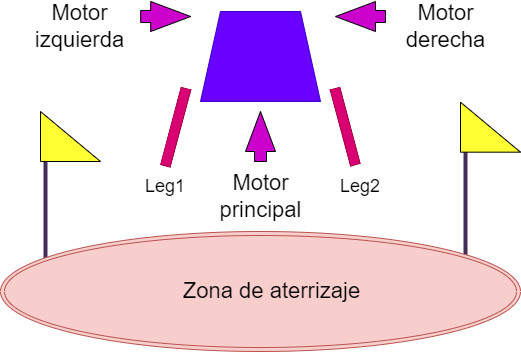

In [ ]:
image = Image.open("./imagenesmario/lunar_lander.png")
display(image)

In [5]:
s = ""
game_input = ['X Coordinate', 'Y Coordinate', 'Linear Veocity X', 'Linear Velocity Y']

game_output = ['left_engine', 'main_engine', 'right_engine']

subclase = ['muy_bajo', 'bajo', 'medio', 'alto']


reglas_texto = binRulestoClassRules(reglas, salidas, game_input, game_output, subclase)

i= 1
for regla in reglas_texto:
    print(r"Regla Nro " + str(i) + ": \n" +  regla)
    print()
    i+=1

Regla Nro 1: 
X Coordinate = muy_bajo and Y Coordinate = bajo and Linear Velocity Y = alto entonces right_engine

Regla Nro 2: 
Y Coordinate = bajo or Y Coordinate = bajo or Y Coordinate = bajo and Linear Veocity X = medio and Linear Velocity Y = alto entonces Not Valid

Regla Nro 3: 
Linear Veocity X = medio entonces left_engine

Regla Nro 4: 
Linear Veocity X = medio and Linear Velocity Y = alto or Linear Velocity Y = alto or Linear Velocity Y = alto entonces left_engine

Regla Nro 5: 
X Coordinate = muy_bajo and Linear Velocity Y = alto entonces main_engine

Regla Nro 6: 
X Coordinate = muy_bajo and Y Coordinate = bajo or Y Coordinate = bajo and Linear Veocity X = medio and Linear Velocity Y = alto entonces main_engine

Regla Nro 7: 
Linear Veocity X = medio and Linear Velocity Y = alto entonces left_engine

Regla Nro 8: 
X Coordinate = muy_bajo and Y Coordinate = bajo and Linear Veocity X = medio entonces right_engine



# Visualización gráfica del ajuste

Text(162.72222222222223, 0.5, 'Ajuste de clasificacion')

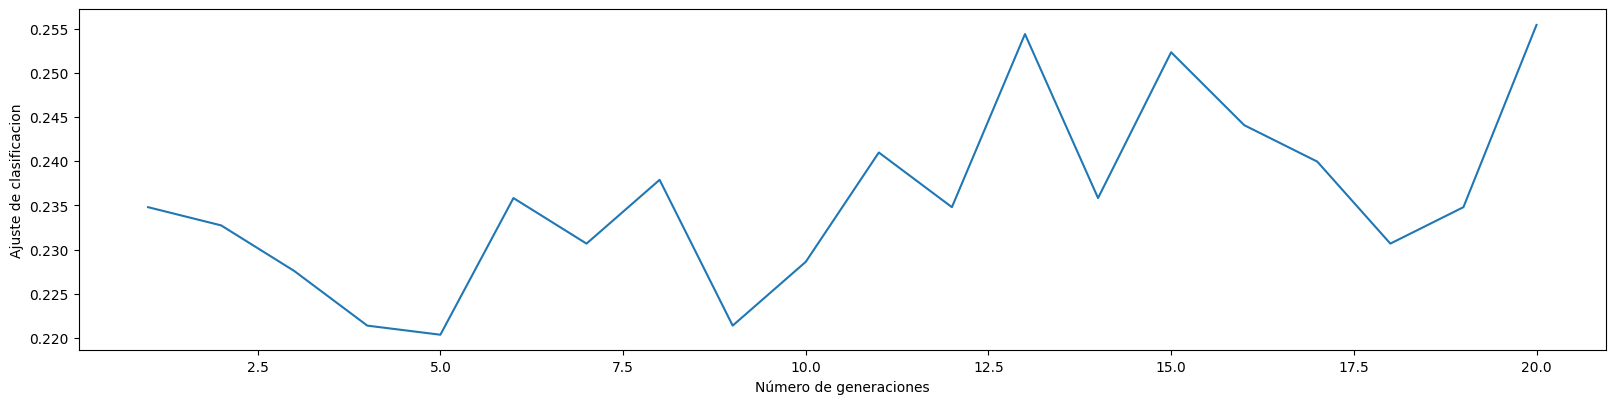

In [6]:
fig, ax = plt.subplots(figsize=(16, 4))
plt.tight_layout()
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], fit_rules)
plt.xlabel('Número de generaciones')
plt.ylabel('Ajuste de clasificacion')

# Ejemplo de juego

![LunarLander](https://www.gymlibrary.dev/_images/lunar_lander.gif "lunar_lander")